In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Set the base path
weights_path = 'results/kdv/weights_u'
data_path = 'results/kdv/data_u'

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import time

In [6]:
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

In [7]:
from koopmanlib.kdv_functions import *
from koopmanlib.functions import *

In [8]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)

# Set the initial conditions.
y0 = kdv_exact(x, seed=123) 

# inner loop
# # Set the time sample grid.
# dt = 0.4 / (Nx**2)
T = 0.01
# Nt = int(T / dt)
# dt = T / Nt
# t = np.linspace(0, T, Nt)

In [9]:
dx

0.049473900056532176

In [10]:
def v_func(x, c):
    return np.exp(-25 * (x - c)**2)

c1, c2, c3 = -np.pi/2, 0, np.pi/2
v1 = v_func(x, c1).reshape(1,-1)
v2 = v_func(x, c2).reshape(1,-1)
v3 = v_func(x, c3).reshape(1,-1)

v_list = np.concatenate([v1,v2,v3], axis=0)

In [11]:
umax = 1
umin = -umax

# Generate data

In [12]:
target_dim = Nx
param_dim = 3
# n_init = 1000
# traj_len = 200

In [13]:
# traj_len = 500

# n_init = 100

# seed_IC = np.random.randint(0,100,size=(n_init,))
# seed_IC

# y0_list = []
# for seed in seed_IC:
#     y0 = kdv_exact(x, seed)
#     y0_list.append(y0)
# y0_list = np.asarray(y0_list)

# y0_list.shape

# param_list_group = np.random.uniform(low=0, high=1, size=(n_init, traj_len, param_dim)) * (umax - umin) + umin

# soln_outer_list = []
# for y0, param_list in zip(y0_list, param_list_group):
#     # Calculate inner solution for each y0 and param_list (for one trajectory)
#     soln_inner_list = [y0]
#     for param in param_list:
#         # Solve the equation using the scipy integrator
#         soln = kdv_solution(y0, t, L, param, v_list)
#         y0 = soln[-1]
#         soln_inner_list.append(y0)

#     soln_inner_list = np.asarray(soln_inner_list)
    
#     soln_outer_list.append(soln_inner_list)
    
# soln_outer_list = np.asarray(soln_outer_list)

# soln_outer_list.shape

# param_list_group.shape

# data_x = soln_outer_list[:,:-1,:].reshape(-1, target_dim)
# data_y = soln_outer_list[:,1:,:].reshape(-1, target_dim)
# data_u = param_list_group.reshape(-1,param_dim)

In [14]:
# # Save the array to a CSV file
# np.savetxt('results/kdv/data/kdv_data_x.csv', data_x, delimiter=',')
# np.savetxt('results/kdv/data/kdv_data_y.csv', data_y, delimiter=',')
# np.savetxt('results/kdv/data/kdv_data_u.csv', data_u, delimiter=',')

In [15]:
# # Load the CSV file
# data_x = np.loadtxt('results/kdv/data/kdv_data_x_500.csv', delimiter=',')
# data_y = np.loadtxt('results/kdv/data/kdv_data_y_500.csv', delimiter=',')
# data_u = np.loadtxt('results/kdv/data/kdv_data_u_500.csv', delimiter=',')

In [16]:
print('load data')
X = pd.read_csv(os.path.join(data_path,'kdv_X.csv'), header=None)
Y = pd.read_csv(os.path.join(data_path,'kdv_Y.csv'), header=None)
U = pd.read_csv(os.path.join(data_path,'kdv_U.csv'), header=None)

data_x = X.values.T
data_y = Y.values.T
data_u = U.values.T

load data


# Build model

In [17]:
from koopmanlib.dictionary import PsiNN, PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

In [18]:
from koopmanlib.param_solver import KoopmanLinearDLSolver

In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
n_psi_train = 3
n_psi = 1 + 1+1 + n_psi_train # constant + momentum + mean + NN

In [21]:
dic_linear = PsiNN_obs(layer_sizes=[16,16], n_psi_train=n_psi_train, dx=dx)

In [22]:
solver_linear = KoopmanLinearDLSolver(dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

In [23]:
model_linear = solver_linear.build_model()

2023-09-19 13:39:59.462785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
zeros_data_y_train = tf.zeros_like(dic_linear(data_y))

In [25]:
# solver_linear.build(model_linear,
#                     data_x,
#                     data_u, 
#                     data_y, 
#                     zeros_data_y_train,
#                     epochs=10,
#                     batch_size=200,
#                     lr=1e-4,
#                     log_interval=20,
#                     lr_decay_factor=0.8)

In [26]:
# solver_linear.model.save_weights(os.path.join(weights_path, 'linear_kdv_mass_momentum_weights_psi3.h5'))

In [27]:
solver_linear.model.load_weights(os.path.join(weights_path, 'linear_kdv_mass_momentum_weights_psi3.h5'))

# Prediction

In [29]:
def compute_linear_obs(y0, param_list, B_obs):
    param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1,-1)
    psi_y = solver_linear.dic.call(y0)
    obs_list = [psi_y@B_obs]
    
    for param in param_list:
        psi_y = solver_linear.model.get_layer('Layer_A')(psi_y) + solver_linear.model.get_layer('Layer_B')(param)
        obs_next = psi_y@B_obs
        obs_list.append(obs_next)
        
    return np.squeeze(np.asarray(obs_list))

In [30]:
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv_solution(y0_loop, T, L, param, v_list,x)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

In [158]:
pred_traj_number = 5
np.random.seed(625)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number,2))

y0_pred_list=[]
param_pred_list = []

Tsim_pred = 0.05
traj_len_pred = int(Tsim_pred / T)

for seed_x, seed_u in seed_list:
    # Forward prediction problem setting
    y0_pred = kdv_exact(x, seed=seed_x) 
    

    # Set the seed of param_list
    np.random.seed(seed_u)

    param_pred = np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
    
    y0_pred_list.append(y0_pred)
    param_pred_list.append(param_pred)



In [159]:
error_mass_list_linear, error_momentum_list_linear = compute_obs_error(dic=dic_linear,
                                                               compute_kdv_soln_func=compute_kdv_soln,
                                                               compute_obs_func_model=compute_linear_obs,
                                                               error_func=compute_diff_ratio_one_traj,
                                                               y0_pred_list=y0_pred_list,
                                                               param_pred_list=param_pred_list,
                                                               dx=dx)

In [160]:
mass_mean_linear, mass_std_linear, mass_mean_plus_linear, mass_mean_minus_linear = compute_stat_info(error_mass_list_linear)
momentum_mean_linear, momentum_std_linear, momentum_mean_plus_linear, momentum_mean_minus_linear = compute_stat_info(error_momentum_list_linear)

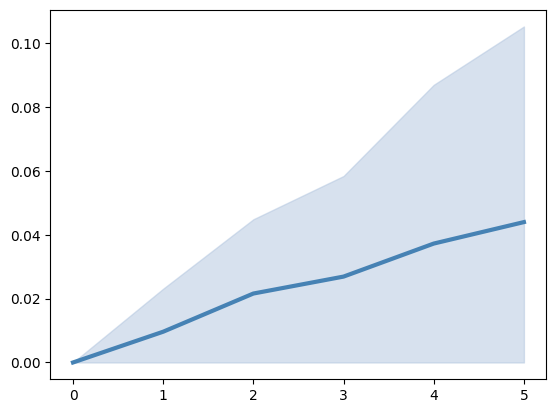

In [161]:
t_axis = np.arange(0, traj_len_pred+1, 1)

plt.plot(mass_mean_linear, label='P-Koopman', color='steelblue', linewidth=3)
plt.fill_between(t_axis, np.maximum(mass_mean_minus_linear,0), mass_mean_plus_linear, color='lightsteelblue', alpha=0.5)

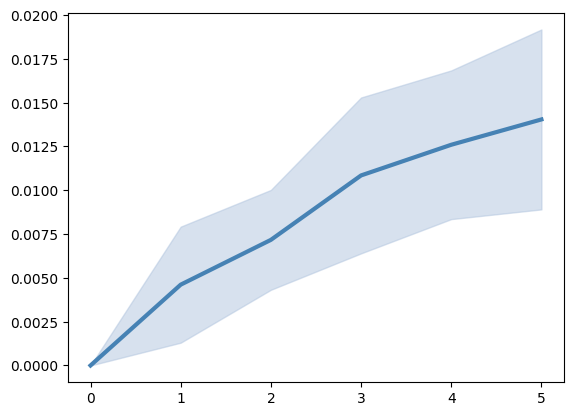

In [162]:
t_axis = np.arange(0, traj_len_pred+1, 1)

plt.plot(momentum_mean_linear, label='P-Koopman', color='steelblue', linewidth=3)
plt.fill_between(t_axis, np.maximum(momentum_mean_minus_linear,0), momentum_mean_plus_linear, color='lightsteelblue', alpha=0.5)

In [163]:
mass_dict_error_linear = {'mean': mass_mean_linear,
             'std': mass_std_linear,
             'mean_plus':mass_mean_plus_linear,
             'mean_minus':mass_mean_minus_linear}
np.save(os.path.join(data_path,'mass_error_linear.npy'), mass_dict_error_linear)


momentum_dict_error_linear = {'mean': momentum_mean_linear,
             'std': momentum_std_linear,
             'mean_plus':momentum_mean_plus_linear,
             'mean_minus':momentum_mean_minus_linear}
np.save(os.path.join(data_path,'momentum_error_linear.npy'), momentum_dict_error_linear)

# Tracking Problem

In [28]:
from scipy.optimize import minimize

In [29]:

Tsim_track = 10

traj_len_track = int(Tsim_track / T)



### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim))+0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5

In [30]:
# Testing reference
y0_track = np.zeros(shape=(Nx, )) + 0.2

In [31]:
# y0_track = kdv_exact(x, seed=10)

In [47]:
tau = 1

In [48]:
# soln_ref = np.loadtxt(os.path.join(data_path,'track_soln_ref'), delimiter=',')

In [49]:
np.savetxt(os.path.join(data_path,'mpc/track_soln_ref.csv'), soln_ref, delimiter=',')

In [50]:
data_path

'results/kdv/data_u'

In [51]:
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1,1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1,1))

In [52]:
def mpc_loss_linear(param, tau, ref_list, y0, B):
    param = tf.reshape(param, shape=(int(param.shape[0]/param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1,-1)
    psi_y = solver_linear.dic.call(y0)
    
    for i in range(tau):
        psi_y = solver_linear.model.get_layer('Layer_A')(psi_y) + solver_linear.model.get_layer('Layer_B')(param[i])
        obs = psi_y@B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs))
        loss_list.append(loss_curr)
    
    ref_loss= tf.reduce_sum(loss_list)
    param_loss = 0.005 * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))
    
    loss = ref_loss + param_loss
    
#     loss = ref_loss
    return loss   

In [53]:
def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss):
    
    bounds= []
    for i in range(tau*param_dim):
        bounds.append((-1,1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []
    for current_time in range(traj_len-tau-1):
        print('current time step: ', current_time)
        start_time = time.time()
        # This needs param_init is a scalor

        param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

        results = minimize(loss, 
                       x0=param_init,
                       args = (tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B),
                       bounds=bounds)

        param = results.x.reshape(tau, param_dim)[0]
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, L, param, v_list, x)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)
        end_time = time.time()

        print('loss: ', results.fun)
#         print('time: ', end_time-start_time)
        
    current_time = current_time + 1
        
    print('current time step: ', current_time)
    start_time = time.time()
    # This needs param_init is a scalor

    param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

    results = minimize(loss, 
                   x0=param_init,
                   args = (tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B),
                   bounds=bounds)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, L, param_curr, v_list, x)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)
        end_time = time.time()

    print('loss: ', results.fun)
        
    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)
    
    return opt_control_list, y0_mpc_loop_list

In [54]:
B_mass = dic_linear.generate_B_mass(mass_ref)
B_momentum = dic_linear.generate_B_momentum(momentum_ref)

## Track mass

In [55]:
linear_opt_control_mass, linear_kdv_opt_mass_soln = KoopmanMPC(y0=y0_track,
                                                               tau=tau,
                                                traj_len=traj_len_track,
                                                soln_ref=mass_ref, 
                                                kdv_solver=kdv_solution,
                                                B=B_mass,
                                                loss=mpc_loss_linear)

current time step:  0
loss:  0.39801886716348445
current time step:  1
loss:  0.39207979058692993
current time step:  2
loss:  0.38622786797381314
current time step:  3
loss:  0.38046148110548733
current time step:  4
loss:  0.37478152276941046
current time step:  5
loss:  0.3691905752031009
current time step:  6
loss:  0.3636803538717518
current time step:  7
loss:  0.3582540443717439
current time step:  8
loss:  0.3529064421815166
current time step:  9
loss:  0.3476395761332474
current time step:  10
loss:  0.3424506791939915
current time step:  11
loss:  0.337338475188362
current time step:  12
loss:  0.3323046817427729
current time step:  13
loss:  0.3273448403720322
current time step:  14
loss:  0.322457554519073
current time step:  15
loss:  0.31764492807414696
current time step:  16
loss:  0.31290464338674023
current time step:  17
loss:  0.3082368119896821
current time step:  18
loss:  0.30363798553593296
current time step:  19
loss:  0.29910633193736935
current time step:  20


loss:  0.03379620884443477
current time step:  165
loss:  0.03329173412128005
current time step:  166
loss:  0.03279485702648046
current time step:  167
loss:  0.032305390045729736
current time step:  168
loss:  0.03182321695032936
current time step:  169
loss:  0.031348368464054144
current time step:  170
loss:  0.030880331419256783
current time step:  171
loss:  0.03041950097276982
current time step:  172
loss:  0.029965480176753306
current time step:  173
loss:  0.02951835226046802
current time step:  174
loss:  0.02907785073456432
current time step:  175
loss:  0.02864376334213981
current time step:  176
loss:  0.028216320510673115
current time step:  177
loss:  0.027795181435728695
current time step:  178
loss:  0.027380530461338835
current time step:  179
loss:  0.026971991040435624
current time step:  180
loss:  0.026569432894758032
current time step:  181
loss:  0.02617284417466629
current time step:  182
loss:  0.025782362778765465
current time step:  183
loss:  0.025397735335

loss:  0.0030938045350692
current time step:  324
loss:  0.0030476254939453508
current time step:  325
loss:  0.0030021352467939316
current time step:  326
loss:  0.0029573331855193173
current time step:  327
loss:  0.002913191578616141
current time step:  328
loss:  0.002869700669301205
current time step:  329
loss:  0.0028268764356252883
current time step:  330
loss:  0.0027846758509861972
current time step:  331
loss:  0.002743134216167064
current time step:  332
loss:  0.002702190822422985
current time step:  333
loss:  0.002661875286397901
current time step:  334
loss:  0.0026221386043702496
current time step:  335
loss:  0.0025830061163561215
current time step:  336
loss:  0.0025444749322029348
current time step:  337
loss:  0.00250649083707877
current time step:  338
loss:  0.0024690755988006664
current time step:  339
loss:  0.0024322209654905006
current time step:  340
loss:  0.0023959262383410765
current time step:  341
loss:  0.0023601630432271777
current time step:  342
los

loss:  0.00030074364185089146
current time step:  479
loss:  0.00029625475656705887
current time step:  480
loss:  0.000291829492020831
current time step:  481
loss:  0.0002874741947308523
current time step:  482
loss:  0.00028318258544743715
current time step:  483
loss:  0.0002789558676066714
current time step:  484
loss:  0.00027479341213179225
current time step:  485
loss:  0.0002706949533830645
current time step:  486
loss:  0.0002666572627427686
current time step:  487
loss:  0.00026267711408504215
current time step:  488
loss:  0.0002587557879301141
current time step:  489
loss:  0.0002548939889856189
current time step:  490
loss:  0.00025109067456744377
current time step:  491
loss:  0.00024734300751762565
current time step:  492
loss:  0.00024365060421654552
current time step:  493
loss:  0.00024001508550481061
current time step:  494
loss:  0.0002364350988087948
current time step:  495
loss:  0.00023290423427978392
current time step:  496
loss:  0.00022942835012668123
current

loss:  0.19848709912945525
current time step:  641
loss:  0.19552681000712488
current time step:  642
loss:  0.19260614590926606
current time step:  643
loss:  0.189731799983544
current time step:  644
loss:  0.18690003596493873
current time step:  645
loss:  0.1841106260552584
current time step:  646
loss:  0.18136255046727878
current time step:  647
loss:  0.17865328794569324
current time step:  648
loss:  0.175987992603463
current time step:  649
loss:  0.17336141282546416
current time step:  650
loss:  0.17077428472825967
current time step:  651
loss:  0.1682252028351029
current time step:  652
loss:  0.16571552090788405
current time step:  653
loss:  0.1632421474166613
current time step:  654
loss:  0.1608057953712379
current time step:  655
loss:  0.15840760867242637
current time step:  656
loss:  0.15604522135682758
current time step:  657
loss:  0.15371817870488616
current time step:  658
loss:  0.15142508471423238
current time step:  659
loss:  0.14916408474592138
current time

loss:  0.017631878440792188
current time step:  802
loss:  0.017368757052359133
current time step:  803
loss:  0.01710932062313128
current time step:  804
loss:  0.016854209080992617
current time step:  805
loss:  0.01660246958545929
current time step:  806
loss:  0.01635445737579902
current time step:  807
loss:  0.016110556164251028
current time step:  808
loss:  0.015869982273374487
current time step:  809
loss:  0.015633125148212378
current time step:  810
loss:  0.015399825569283869
current time step:  811
loss:  0.015170178158157343
current time step:  812
loss:  0.014943944641956183
current time step:  813
loss:  0.014720890721726294
current time step:  814
loss:  0.01450100657221622
current time step:  815
loss:  0.014284653656991395
current time step:  816
loss:  0.014071454598832198
current time step:  817
loss:  0.013861262126825103
current time step:  818
loss:  0.013654482634156584
current time step:  819
loss:  0.013450767503111688
current time step:  820
loss:  0.0132500

loss:  0.0016386085900944366
current time step:  960
loss:  0.0016141735113093414
current time step:  961
loss:  0.001590076346170156
current time step:  962
loss:  0.001566363972328989
current time step:  963
loss:  0.0015429597999764388
current time step:  964
loss:  0.0015199137556320518
current time step:  965
loss:  0.001497216217857859
current time step:  966
loss:  0.001474864514171324
current time step:  967
loss:  0.0014528582151159845
current time step:  968
loss:  0.0014311710605387582
current time step:  969
loss:  0.0014098202717371864
current time step:  970
loss:  0.0013887758949612035
current time step:  971
loss:  0.0013680427543488643
current time step:  972
loss:  0.0013476455065275462
current time step:  973
loss:  0.0013275316418996854
current time step:  974
loss:  0.0013077224253160314
current time step:  975
loss:  0.0012882069140300939
current time step:  976
loss:  0.001268974504098224
current time step:  977
loss:  0.00125003918851328
current time step:  978


In [56]:
# np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_linear_mass_kdv_opt_control.csv'), linear_opt_control_mass, delimiter=',')
# np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_linear_mass_kdv_opt_soln.csv'), linear_kdv_opt_mass_soln, delimiter=',')

In [57]:
# linear_opt_control_mass = np.loadtxt(os.path.join(data_path,'linear_mass_kdv_opt_control_20s_greedy.csv'), delimiter=',')
# linear_kdv_opt_mass_soln = np.loadtxt(os.path.join(data_path,'linear_mass_kdv_opt_soln_20s_greedy.csv'), delimiter=',')

In [58]:
linear_kdv_opt_mass = dx * tf.reduce_sum(linear_kdv_opt_mass_soln, axis=-1)

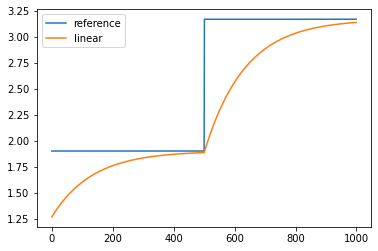

In [59]:
plt.plot(mass_ref, label='reference')
plt.plot(linear_kdv_opt_mass, label='linear')
plt.legend()

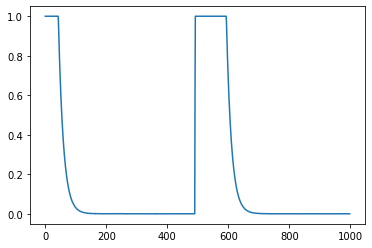

In [45]:
plt.plot(linear_opt_control_mass[:,0])

# Track momentum

In [46]:
linear_opt_control_momentum, linear_kdv_opt_momentum_soln = KoopmanMPC(y0=y0_track,
                                                                       tau=tau,
                                                traj_len=traj_len_track,
                                                soln_ref=momentum_ref, 
                                                kdv_solver=kdv_solution,
                                                B=B_momentum,
                                                loss=mpc_loss_linear)

current time step:  0
loss:  0.9997531025807249
current time step:  1
loss:  0.9959925918530861
current time step:  2
loss:  0.9922412709176042
current time step:  3
loss:  0.9884956473812456
current time step:  4
loss:  0.9847597767694455
current time step:  5
loss:  0.9810339941118593
current time step:  6
loss:  0.9773175044257807
current time step:  7
loss:  0.9736118678065268
current time step:  8
loss:  0.9699161530354036
current time step:  9
loss:  0.9662247725036301
current time step:  10
loss:  0.9625438548294879
current time step:  11
loss:  0.9588522824626877
current time step:  12
loss:  0.9551637640273638
current time step:  13
loss:  0.9514909983425212
current time step:  14
loss:  0.9478304090537844
current time step:  15
loss:  0.9441855793696293
current time step:  16
loss:  0.9405518365372975
current time step:  17
loss:  0.9369265006668727
current time step:  18
loss:  0.9333052505787118
current time step:  19
loss:  0.9296985236122671
current time step:  20
loss:  

loss:  0.49334099922547464
current time step:  167
loss:  0.49104692052029897
current time step:  168
loss:  0.4887657478497237
current time step:  169
loss:  0.48648431672250664
current time step:  170
loss:  0.48420710075896245
current time step:  171
loss:  0.48194629768239944
current time step:  172
loss:  0.47969027907197115
current time step:  173
loss:  0.477440949183195
current time step:  174
loss:  0.4751998171296673
current time step:  175
loss:  0.4729794298609912
current time step:  176
loss:  0.47077486030723403
current time step:  177
loss:  0.46856970965172917
current time step:  178
loss:  0.46636520963054423
current time step:  179
loss:  0.46417704391400033
current time step:  180
loss:  0.46199815067962485
current time step:  181
loss:  0.4598294735680002
current time step:  182
loss:  0.4576888989883556
current time step:  183
loss:  0.4555379592410556
current time step:  184
loss:  0.45339727547614345
current time step:  185
loss:  0.4512645331015336
current time 


KeyboardInterrupt



In [ ]:
linear_kdv_opt_momentum = dx * tf.reshape(tf.math.reduce_sum(tf.square(linear_kdv_opt_momentum_soln), axis=-1), shape=(-1,1))

In [ ]:
plt.plot(momentum_ref, label='reference')
plt.plot(linear_kdv_opt_momentum, label='linear')
plt.legend()

In [ ]:
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_linear_momentum_kdv_opt_control.csv'), linear_opt_control_momentum, delimiter=',')
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_linear_momentum_kdv_opt_soln.csv'), linear_kdv_opt_momentum_soln, delimiter=',')

# Controllability

In [68]:
# Randomly sample control
np.random.seed(seed=111)
n_control_samples = 2000
control_samples = np.random.uniform(low=0, high=1, size=(n_control_samples, param_dim)) * (umax - umin) + umin

In [69]:
vector_bu = solver_linear.model.get_layer('Layer_B')(control_samples)

In [70]:
solver_linear.model.get_layer('Layer_B').weights

[<tf.Variable 'Layer_B/kernel:0' shape=(3, 4) dtype=float64, numpy=
 array([[-1.30104261e-17,  6.84490017e-02, -7.48895866e-04,
          2.08050131e-04],
        [-9.25908655e-17,  6.86751627e-02, -5.40985905e-04,
          3.15769172e-04],
        [-3.45535232e-16,  6.86216604e-02, -8.40655009e-04,
          3.86985534e-04]])>]

In [71]:
control_samples.shape

(2000, 3)

In [72]:
vector_bu = tf.reshape(vector_bu, shape=(vector_bu.shape[0],n_psi,1))

In [73]:
vector_zeros = tf.zeros(shape=(vector_bu.shape[0], n_psi, n_psi-1), dtype='float64')

In [74]:
matrix_bu = tf.concat([vector_bu, vector_zeros], axis=-1)

In [75]:
matrix_bu[0]

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[ 1.02551195e-16,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.88729764e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.97554246e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.11809569e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])>

In [76]:
# Create a 3x3 identity matrix
identity_matrix = np.eye(n_psi)

In [77]:
matrix_A = solver_linear.model.get_layer('Layer_A')(identity_matrix)

In [78]:
matrix_A

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[ 1.00000000e+00,  1.09276740e-03, -1.49643422e-03,
         9.23807438e-04],
       [-9.80118764e-17,  9.99806932e-01, -6.53436978e-05,
        -4.74398849e-05],
       [-2.22044605e-16, -6.21362578e-03,  1.00227680e+00,
        -3.83239310e-03],
       [ 4.99600361e-15,  2.24902565e-02,  2.11449817e-02,
         1.00015566e+00]])>

In [79]:
linear_K_matrix = matrix_bu + matrix_A

In [80]:
linear_A_matrix = (linear_K_matrix - identity_matrix) / T

linear_A_vector = tf.reshape(linear_A_matrix, shape=(linear_A_matrix.shape[0], linear_A_matrix.shape[-1]*linear_A_matrix.shape[-1]))

rank = np.linalg.matrix_rank(linear_A_vector)

U, S, VT = np.linalg.svd(linear_A_vector)

In [81]:
np.sum(S > 1e-5)

4

In [162]:
S

array([3.00907567e+02, 1.42514091e+02, 5.66001169e-01, 3.23417390e-01,
       6.93493129e-13, 2.87072870e-13, 4.13389705e-15, 1.04323524e-17,
       9.59488603e-18, 2.66896110e-18, 1.23800720e-18, 4.75004906e-19,
       1.53639253e-19, 7.46375738e-22, 1.18486091e-29, 7.99100638e-34])

In [83]:
# Check the rank of psi_y

psi_x = dic_linear(data_x[:2000,:])

U_x, S_x, VT_x = np.linalg.svd(psi_x.numpy())

S_x

array([9.32550612e+02, 4.32186938e+01, 1.64202796e+00, 3.39976981e-01])

In [419]:
solver_linear.model.weights

[<tf.Variable 'dic_nn_2/dense_8/kernel:0' shape=(128, 16) dtype=float64, numpy=
 array([[-0.11946949,  0.10629108,  0.18487545, ...,  0.11274908,
         -0.09162138,  0.00824665],
        [ 0.18563213, -0.156174  , -0.0045291 , ..., -0.15788919,
         -0.09166432, -0.04920634],
        [ 0.1732359 ,  0.10672823, -0.13551614, ..., -0.02894821,
          0.11614003,  0.00164874],
        ...,
        [-0.11947453,  0.12054729,  0.15148409, ...,  0.04197183,
         -0.15330199,  0.05307735],
        [-0.02813545, -0.16716774,  0.11357821, ..., -0.14975024,
         -0.10167409,  0.11073917],
        [ 0.12513555, -0.11729631, -0.09243388, ...,  0.0581396 ,
          0.00727545, -0.05674344]])>,
 <tf.Variable 'dic_nn_2/dense_9/kernel:0' shape=(16, 16) dtype=float64, numpy=
 array([[ 0.09522783,  0.26683524, -0.27230335,  0.15621851, -0.08574116,
         -0.17291086,  0.01433219, -0.1839895 ,  0.05030646,  0.01995397,
         -0.44700642,  0.24709881, -0.12161446, -0.25454854, -0.0

In [425]:
weights_A = solver_linear.model.get_layer('Layer_A').weights[0].numpy()
weights_B = solver_linear.model.get_layer('Layer_B').weights[0].numpy()

In [426]:
matrix_check = weights_B @ B_mass @ B_mass.T @ weights_B.T

In [427]:
matrix_check

array([[1.14677076e-05, 1.15059251e-05, 1.14967685e-05],
       [1.15059251e-05, 1.15442699e-05, 1.15350828e-05],
       [1.14967685e-05, 1.15350828e-05, 1.15259030e-05]])